In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Baseline GNN Training

Here, I train a basic GNN with node features, not including target information or mean encoded target information.  Nodes are businesses or NAICS, with edges to the exact match NAICS or same-sector NAICS.

Batching is used for training, and nodes are sampled at each layer.  I use a 2-layer GNN

Refs
  * https://www.tensorflow.org/guide/keras/serialization_and_saving
  * http://stellargraph.readthedocs.io/en/v1.2.0/api.html
  * https://github.com/tensorflow/tensorflow/issues/46659
  * https://stackoverflow.com/questions/59493222/access-output-of-intermediate-layers-in-tensor-flow-2-0-in-eager-mode

*This script takes about 2 hours on my MacBook Air*

In [3]:
import pandas as pd
import numpy as np

In [4]:
from pathlib import Path
import importlib
import pickle

In [5]:
import stellargraph as sg
from stellargraph.layer import HinSAGE
from stellargraph.mapper import HinSAGENodeGenerator

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import keras
import tensorflow.keras.metrics as km
from keras import initializers
import tensorflow as tf

2023-12-16 22:30:56.719005: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-16 22:30:56.719028: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-16 22:30:56.719034: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-16 22:30:56.719069: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-16 22:30:56.719091: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Import Data
Import Stellargraph dataset for training

##### Heterogeneous graph

In [6]:
# Training and validation clients - monitor training on val clients
with open(Path(setup.temp_path).joinpath('11_DATA_stellargraph_train_val.pkl'), 'rb') as fin:
      sba_graph  = pickle.load(fin)

In [7]:
print(sba_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 544895, Edges: 54210785

 Node types:
  LoanNr_ChkDgt: [543584]
    Features: float32 vector, length 10
    Edge types: LoanNr_ChkDgt-loan_naics->NAICS, LoanNr_ChkDgt-loan_sector_naics->NAICS
  NAICS: [1311]
    Features: float32 vector, length 9
    Edge types: NAICS-loan_naics->LoanNr_ChkDgt, NAICS-loan_sector_naics->LoanNr_ChkDgt

 Edge types:
    LoanNr_ChkDgt-loan_sector_naics->NAICS: [53667201]
        Weights: all 1 (default)
        Features: none
    LoanNr_ChkDgt-loan_naics->NAICS: [543584]
        Weights: all 1 (default)
        Features: none


##### Labels

In [8]:
label_data = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_labels_train_val.parquet'))

## Process labels
Get separate train, test label dataframes.  Also get initial target rate (for metric tracking)

In [10]:
train_labels = label_data[label_data['dset'] == 'train'].drop(columns=['dset']).set_index('LoanNr_ChkDgt')
val_labels = label_data[label_data['dset'] == 'val'].drop(columns=['dset']).set_index('LoanNr_ChkDgt')
print(f'this graph labels shape {label_data.shape}')
print(f'train labels shape {train_labels.shape}')
print(f'validation labels shape {val_labels.shape}')

this graph labels shape (543584, 4)
train labels shape (447252, 2)
validation labels shape (96332, 2)


In [11]:
vc = train_labels['target'].value_counts(normalize=True)
base_thresh = vc.loc[1]
print(f'target rate: {base_thresh}')

target rate: 0.20301083058320588


## Train

##### Set seeds to setup

In [14]:
# Set some seeds
np.random.seed(16)
tf.random.set_seed(16)
sg.random.set_seed(4345)

##### Node Predictor Generator and "Flows"
Create objects to train on train cases, monitor on validation cases

In [15]:
generator = HinSAGENodeGenerator(sba_graph, batch_size=40, 
                                 num_samples=[10, 20], 
                                 head_node_type='LoanNr_ChkDgt',
                                 seed=2454)

In [17]:
train_gen = generator.flow(train_labels.index, train_labels['target'], shuffle=True)

In [18]:
val_gen = generator.flow(val_labels.index, val_labels['target'], shuffle=False)

##### Create HinSage model (a Keras model)

In [21]:
graphsage_model = HinSAGE(
    layer_sizes=[8, 8], generator=generator, bias=True, dropout=0.5,
)

In [22]:
tf.random.set_seed(16)
keras.utils.set_random_seed(812)
sg.random.set_seed(4345)

In [23]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=676))(x_out) 

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [24]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss = losses.binary_crossentropy,  
    metrics=["acc", km.AUC(curve='PR'), km.Precision(thresholds=base_thresh), 
             km.Recall(thresholds=base_thresh)],
)

##### Fit model

In [22]:
history = model.fit(
    train_gen, epochs=20, validation_data=val_gen, verbose=2, shuffle=False
)

Epoch 1/20


2023-12-14 20:53:19.922262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 20:58:41.496472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5591/5591 - 457s - loss: 0.4962 - acc: 0.7951 - auc: 0.2497 - precision: 0.2446 - recall: 0.6734 - val_loss: 0.4791 - val_acc: 0.7970 - val_auc: 0.2992 - val_precision: 0.2737 - val_recall: 0.6642 - 457s/epoch - 82ms/step
Epoch 2/20
5591/5591 - 454s - loss: 0.4808 - acc: 0.7970 - auc: 0.2925 - precision: 0.2748 - recall: 0.6860 - val_loss: 0.4785 - val_acc: 0.7970 - val_auc: 0.3038 - val_precision: 0.2671 - val_recall: 0.7571 - 454s/epoch - 81ms/step
Epoch 3/20
5591/5591 - 20126s - loss: 0.4795 - acc: 0.7970 - auc: 0.2958 - precision: 0.2760 - recall: 0.6966 - val_loss: 0.4779 - val_acc: 0.7970 - val_auc: 0.3045 - val_precision: 0.2685 - val_recall: 0.7803 - 20126s/epoch - 4s/step
Epoch 4/20
5591/5591 - 15013s - loss: 0.4785 - acc: 0.7970 - auc: 0.2988 - precision: 0.2768 - recall: 0.7033 - val_loss: 0.4792 - val_acc: 0.7970 - val_auc: 0.3023 - val_precision: 0.2700 - val_recall: 0.7516 - 15013s/epoch - 3s/step
Epoch 5/20
5591/5591 - 13720s - loss: 0.4779 - acc: 0.7970 - auc: 0.3008 - 

In [23]:
# Tensorflow save format to work around issue 
# https://github.com/tensorflow/tensorflow/issues/46659
model.save(Path(setup.temp_path).joinpath('12_DATA_model.keras'),
          save_format='tf')

## Training Curves

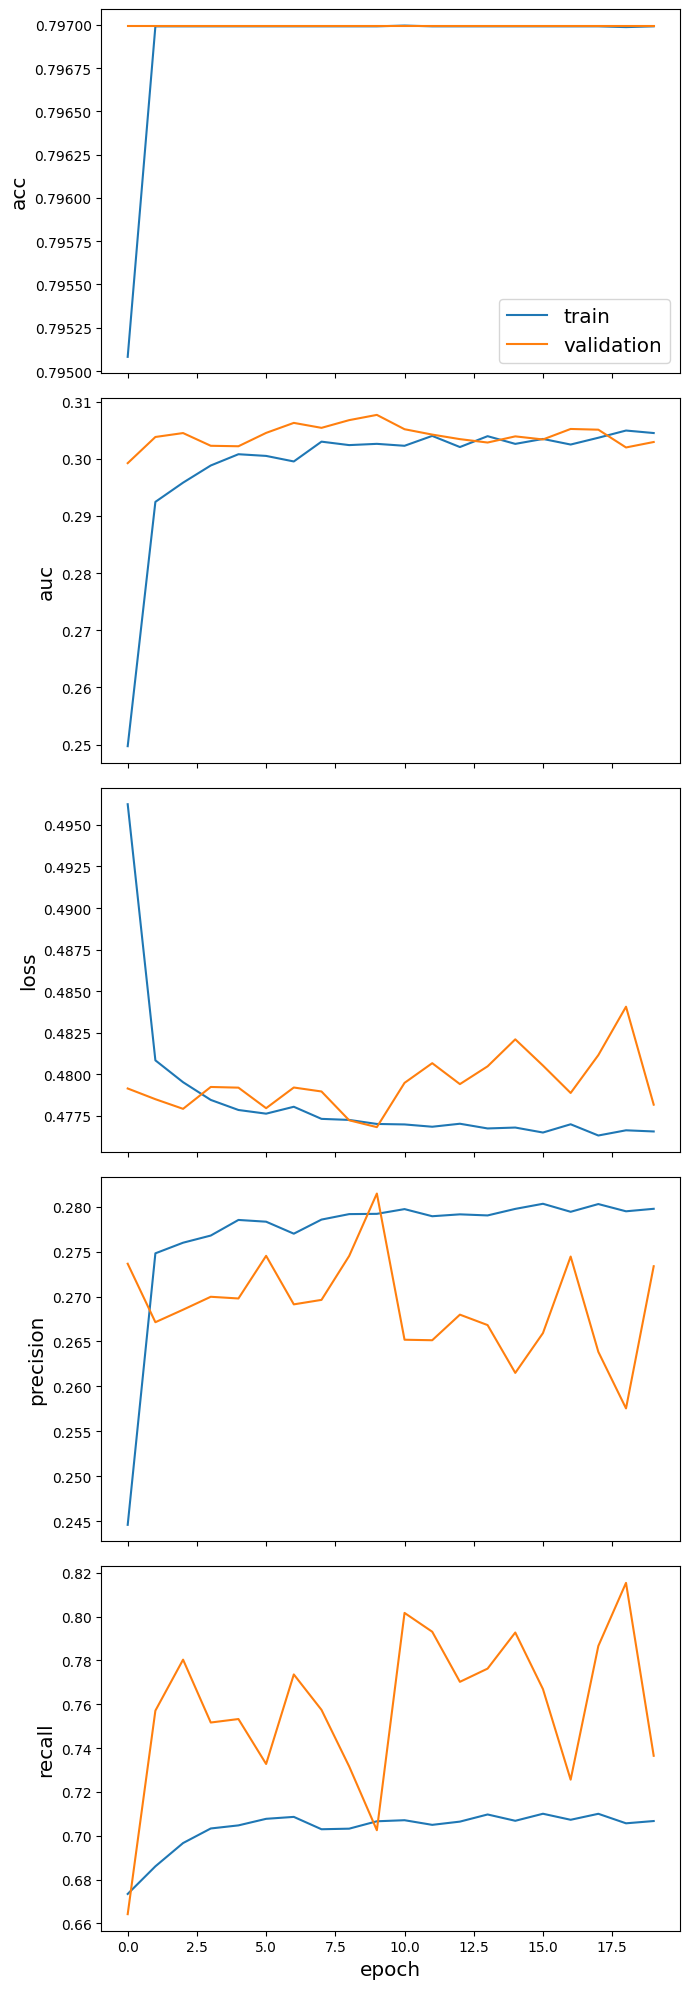

In [25]:
sg.utils.plot_history(history)

In [26]:
pd.DataFrame(history.history).to_csv(Path(setup.temp_path).joinpath('12_REPORT_fit_progress.csv'))

## Metrics

In [27]:
train_test_metrics = model.evaluate(val_gen)

2409/2409 [==============================] - 87s 36ms/step - loss: 0.4780 - acc: 0.7970 - auc: 0.3053 - precision: 0.2730 - recall: 0.7356


In [28]:
train_metrics = model.evaluate(train_gen)

5591/5591 [==============================] - 202s 36ms/step - loss: 0.4730 - acc: 0.7970 - auc: 0.3067 - precision: 0.2803 - recall: 0.7223


In [29]:
metrics = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_test_metrics])))],
                        keys=['train', 'test'])
metrics.to_csv(Path(setup.temp_path).joinpath('12_REPORT_train_metrics.pkl'), index=True)
metrics

,,loss,acc,auc,precision,recall
train,0,0.473036,0.796991,0.306733,0.280278,0.722323
test,0,0.478022,0.796994,0.305302,0.273036,0.735631
